In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logit
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [2]:
def int_logit(b0, b1, x):
    return np.log(np.exp(b0 + b1 * x) + 1) / b1


def avg_prob(b0, b1, x_max, x_min):
    return int_logit(b0, b1, x_max) - int_logit(b0, b1, x_min)


# Toy Experiment

1. Pick sample size: $N \ \ (=10,000,000)$
2. Pick true values of two parameters: $\beta_0$ and $\beta_1$.
3. Generate `X`: $x_i$ `~ unif[0,1]` ($i=1, ..., N$)
4. Generate `y`: $y_i$ with the probability of events for each $x_i$:
   $$P(y_i=1 | x_i, \beta_0, \beta_1) = \cfrac{1}{1 + e^{-\beta_0-\beta_1 x}}$$
5. Run logistic regression estimation with `(X,y)` to get the MLE: $\hat{\beta_0}$ and $\hat{\beta_1}$.
6. Compare ($\hat{\beta_0}$ , $\hat{\beta_1}$) with ($\beta_0$ , $\beta_1$).


In [3]:
np.random.seed(0)
list_params = [(1, 2), (-1, -3), (-4, -6), (-7, -9), (-8, -10)]
N = 1000000
list_df = []
for i, (true_b0, true_b1) in enumerate(list_params):
    X = np.random.uniform(0, 1, N)
    prob = 1 / (1 + np.exp(-true_b0 - true_b1 * X))
    y = np.random.binomial(size=N, n=1, p=prob)
    model = LogisticRegression(penalty=None).fit(X.reshape([N, 1]), y)
    est_b0, est_b1 = model.intercept_[0], model.coef_[0][0]
    list_df.append(
        pd.DataFrame(
            {
                "Case": [f"#{i+1}"] * 2,
                "True": [true_b0, true_b1],
                "Estimated": [est_b0, est_b1],
                "Params": ["b0", "b1"],
                "Probability of Events": [avg_prob(true_b0, true_b1, 1, 0)] * 2,
            }
        )
    )
df_exp = pd.concat(list_df, axis=0, ignore_index=True).sort_values("Params")


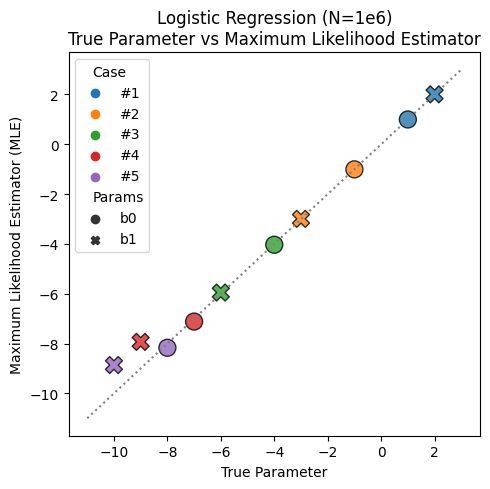

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
hue = df_exp[["Params", "Case"]].apply(lambda row: f"{row.Params}, {row.Case}", axis=1)
hue.name = "Params, Case"
sns.scatterplot(
    data=df_exp,
    x="True",
    y="Estimated",
    hue="Case",
    style="Params",
    s=150,
    alpha=0.8,
    ax=ax,
    edgecolor="k",
)
x = np.linspace(-11, 3, 100)
ax.plot(x, x, ls=":", color="gray")
ax.set_xlabel("True Parameter")
ax.set_ylabel("Maximum Likelihood Estimator (MLE)")
ax.set_title(
    "Logistic Regression (N=1e6)\nTrue Parameter vs Maximum Likelihood Estimator"
)
fig.tight_layout()
fig.savefig("fig1_toy_experiment.png", dpi=200, facecolor="white")


#### Observations
- ($\hat{\beta_0}$ , $\hat{\beta_1}$) are fairly close to ($\beta_0$ , $\beta_1$) in **#1**, **#2**, and **#3**, but not in **#4** and **#5**. 
- When the probablity of events is very small, the MLEs are biased 
- We used the same $N(=10^6)$ in all cases.

# Monte Carlo Simulation

In order to get better sense of what is going on, let's draw more random numbers along with various configurations:
 
* $P$ (probability of events): [50%, 11.2%, 5.73%, 1.17%, 0.59%, 0.12%]
* $N$: [10000, 50000, 100000, 500000, 1000000]

In each combination {$P,N$}, we generate $M$ ensembles of MLEs ($\hat\beta^{(m)}$ where $m=1, ..., M$) and calculate the following error metric:
$$\textsf{Mean Absolute Relative Error (MARE)}=\displaystyle \sum_{m=1}^M\cfrac{|\hat\beta^{(m)}-\beta|}{|\beta|}$$



In [5]:
M = 200  # simulation numbers
probs = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]  # (auxiliary) average probability
N_samples = [10000, 50000, 100000, 500000, 1000000]  # number of samples
logit_p = logit(probs)
true_b1 = np.array([-2] * len(probs))
true_b0 = logit_p - 0.5 * true_b1


In [6]:
filename = "df_simulation_results.parquet"
if os.path.exists(filename):
    df = pd.read_parquet(filename)
else:
    list_df = []
    for m in range(M):
        for i, p in enumerate(probs):
            b0, b1 = true_b0[i], true_b1[i]
            prob_avg = avg_prob(b0, b1, 1, 0)
            for N in N_samples:
                X = np.random.uniform(0, 1, N)
                prob = 1 / (1 + np.exp(-b0 - b1 * X))
                y = np.random.binomial(size=N, n=1, p=prob)
                model = LogisticRegression(penalty=None).fit(X.reshape([N, 1]), y)
                df = pd.DataFrame(
                    data={
                        "sim_num": [m],
                        "prob_aux": [p],
                        "prob": [prob_avg],
                        "N": [N],
                        "N_events": y.sum(),
                        "est_b1": [model.coef_[0][0]],
                        "true_b1": [b1],
                        "est_b0": [model.intercept_[0]],
                        "true_b0": [b0],
                    }
                )
                list_df.append(df)
    df = pd.concat(list_df, axis=0, ignore_index=True)
    df.to_parquet(filename)


#### In the below is the extended results of the above toy experiment.

# Plot by Probability of Events


In [7]:
df_plot = (
    (
        df.assign(ARE_b1=abs(df["est_b1"] / df["true_b1"] - 1)).assign(
            ARE_b0=abs(df["est_b0"] / df["true_b0"] - 1)
        )
    )
    .groupby(["prob", "N"])
    .mean()
    .reset_index()
    .rename(columns={"ARE_b0": "MARE_b0", "ARE_b1": "MARE_b1"})
)


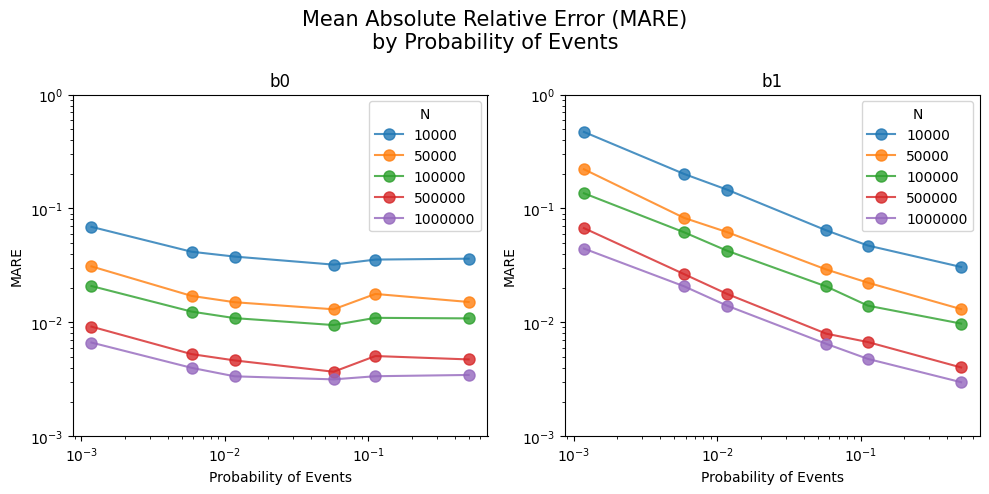

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
coefs = ["b0", "b1"]
for i, ax in enumerate(
    axes.reshape(
        2,
    )
):
    df_plot.pivot_table(index="prob", columns="N", values=f"MARE_{coefs[i]}").plot(
        ax=ax, marker="o", markersize=8, alpha=0.8
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim([1e-3, 1])
    ax.set_ylabel("MARE")
    ax.set_xlabel("Probability of Events")
    ax.set_title(f"{coefs[i]}", size=12)
fig.suptitle(
    f"Mean Absolute Relative Error (MARE)\nby Probability of Events",
    size=15,
)
fig.tight_layout()
fig.savefig("fig2_MC_by_prob.png", dpi=200, facecolor="white")


####  The error increases with respect to the probabiltiy of events.

# Plot by Number of Events


In [9]:
df_plot = (
    (
        df.assign(ARE_b1=abs(df["est_b1"] / df["true_b1"] - 1))
        .assign(ARE_b0=abs(df["est_b0"] / df["true_b0"] - 1))
        .assign(N_events_theo=df["N"] * df["prob"])
        .assign(
            N=df["N"].astype(
                pd.CategoricalDtype(categories=sorted(df["N"].unique()), ordered=True)
            )
        )
    )
    .groupby(["N", "N_events_theo"])
    .mean()
    .reset_index()
    .rename(columns={"ARE_b0": "MARE_b0", "ARE_b1": "MARE_b1"})
)


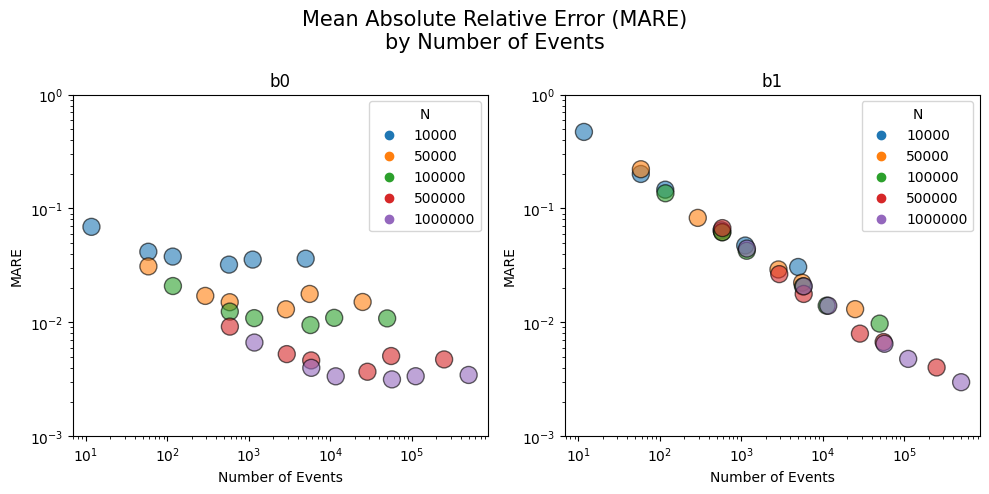

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
coefs = ["b0", "b1"]

for i, ax in enumerate(
    axes.reshape(
        2,
    )
):
    sns.scatterplot(
        data=df_plot,
        x="N_events_theo",
        y=f"MARE_{coefs[i]}",
        hue="N",
        s=150,
        alpha=0.6,
        edgecolor="k",
        ax=ax,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim([1e-3, 1])
    ax.set_ylabel("MARE")
    ax.set_xlabel("Number of Events")
    ax.set_title(f"{coefs[i]}", size=12)
fig.suptitle(f"Mean Absolute Relative Error (MARE)\nby Number of Events", size=15)
fig.tight_layout()
fig.savefig("fig3_MC_by_events.png", dpi=200, facecolor="white")


#### Regardless of $N$, the actual number of events determines the error level!